## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] 
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    # print(epsilon)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        possible_moves = [i for i in env.action_space(state)[0]]        
        action = possible_moves[np.random.choice(range(len(possible_moves)))]    #Exploration: randomly choosing and action
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(7,7)),('x-x-x-x-x-x-x-x-x',(5,9)),
                       ('x-4-x-x-3-x-x-x-x',(8,5)),('6-x-x-9-x-x-x-x-x',(3,1))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [11]:
EPISODES = 5000000
LR = 0.01                   # learning rate
GAMMA = 0.8                 # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.000001        # epsilon decay rate
threshold = 200            # number of episodes after which states_tracked will be saved
policy_threshold = 30000    # number of episodes after which Q_dict will be saved

### Q-update loop ---write your code here

In [12]:
start_time = time.time()
win_total = 0
tie_total = 0
lost_total = 0
for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe() # init the environment

    curr_state = env.state    
    terminal_s = False
    
    
    add_to_dict(curr_state)

    while terminal_s != True:  
        curr_state1 = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)   

        next_state, reward, terminal_s = env.step(curr_state, curr_action)
        next_state1 = Q_state(next_state)
        add_to_dict(next_state)

        # UPDATE RULE
        if terminal_s != True:
            max_next = max(Q_dict[next_state1],key=Q_dict[next_state1].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state1][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 

        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))
            if reward == 0:
                tie_total += 1
            elif reward == -10:
                lost_total += 1
            else:
                win_total+=1

        curr_state = next_state
        
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')
        #print(episode) 

    if ((episode+1)% policy_threshold) == 0:  #every policy_threshold episodes, the Q_dict will be saved
        save_obj(Q_dict,'Policy') 
        
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

In [13]:
print("Percentage of agent won the game ",round((win_total/EPISODES)*100,2))
print("Percentage of agent got tie with the environment ",round((tie_total/EPISODES)*100,2))
print("Percentage of agent lost to environment ",round((lost_total/EPISODES)*100,2))

Percentage of agent won the game  39.33
Percentage of agent got tie with the environment  59.22
Percentage of agent lost to environment  1.44


#### Check the Q-dictionary

In [14]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.3007168033279173,
              (0, 3): -1.3005912219366287,
              (0, 5): -1.2619298610844867,
              (0, 7): -1.3065096313483622,
              (0, 9): 1.9145849360185612,
              (1, 1): -0.9215778915460797,
              (1, 3): -1.3009398422438783,
              (1, 5): 0.4327865857872875,
              (1, 7): -1.2995468143267905,
              (1, 9): -1.2677091844067956,
              (2, 1): -1.1934030724840732,
              (2, 3): -1.3086711259298807,
              (2, 5): -0.3489921387642515,
              (2, 7): -1.3010537460485003,
              (2, 9): -1.260829236421866,
              (3, 1): -1.3120124718271016,
              (3, 3): -1.3114258274818538,
              (3, 5): -1.3108910942776415,
              (3, 7): -1.311202241860881,
              (3, 9): -1.3107675412954847,
              (4, 1): -1.312144375642262,
              (4, 3): -1.312124133858511,
              (4, 5):

In [15]:
len(Q_dict)

2653584

In [16]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
max(Q_dict['x-x-x-x-x-x-x-x-x'],key=Q_dict['x-x-x-x-x-x-x-x-x'].get)

(0, 9)

#### Check the states tracked for Q-values convergence
(non-evaluative)

<function matplotlib.pyplot.show(*args, **kw)>

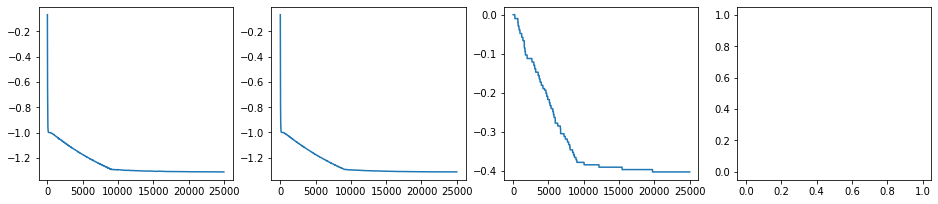

In [17]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(7,7)])))
plt.subplot(241)
plt.plot(xaxis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(7,7)]))
plt.show

xaxis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(5,9)])))
plt.subplot(242)
plt.plot(xaxis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(5,9)]))
plt.show

xaxis = np.asarray(range(0, len(States_track['x-4-x-x-3-x-x-x-x'][(8,5)])))
plt.subplot(243)
plt.plot(xaxis,np.asarray(States_track['x-4-x-x-3-x-x-x-x'][(8,5)]))
plt.show


xaxis = np.asarray(range(0, len(States_track['6-x-x-9-x-x-x-x-x'][(3,1)])))
plt.subplot(244)
plt.plot(xaxis,np.asarray(States_track['6-x-x-9-x-x-x-x-x'][(3,1)]))
plt.show

### Epsilon - decay check

In [18]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

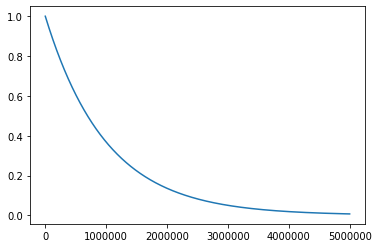

In [19]:
plt.plot(time, epsilon)
plt.show()